# Installation & Setup

In [ ]:
!pip install soundfile scipy kaggle torch torchvision torchaudio
!pip install kagglehub

In [ ]:
!pip install git+https://github.com/ml-jku/hopfield-layers

  Cloning https://github.com/ml-jku/hopfield-layers to /tmp/pip-req-build-s99oukj4
  Running command git clone --filter=blob:none --quiet https://github.com/ml-jku/hopfield-layers /tmp/pip-req-build-s99oukj4
  Resolved https://github.com/ml-jku/hopfield-layers to commit f56f929c95b77a070ae675ea4f56b6d54d36e730
  Preparing metadata (setup.py) ... done
  Created wheel for hopfield-layers: filename=hopfield_layers-1.0.2-py3-none-any.whl size=25586 sha256=fee9ade3518ce7f4b967e0d825dadaf6da6daaffce75153ad142cf1013f567a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-_75wp7_q/wheels/32/18/8e/6a0676bf7ffad419e7ce03acf68a3b21bde9ba7659199e73f3
Successfully built hopfield-layers


In [ ]:
!pip install imbalanced-learn


In [ ]:
import os
import numpy as np
import pandas as pd
import soundfile as sf
from scipy.signal import butter, sosfilt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from hflayers import Hopfield, HopfieldLayer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Audio Pre-processing


In [ ]:
class AudioPreProcessor:
    """Bandpass filtering and feature extraction for audio"""

    def __init__(self, sr=16000, lowcut=500.0, highcut=7000.0, filter_order=4):
        self.sr = sr
        nyquist = 0.5 * sr
        low = lowcut / nyquist
        high = highcut / nyquist
        self.sos = butter(filter_order, [low, high], btype='band', output='sos')

    def bandpass_filter(self, audio):
        """Apply bandpass filter to audio"""
        zi = np.zeros((self.sos.shape[0], 2))
        filtered, _ = sosfilt(self.sos, audio, zi=zi)
        return filtered

    def extract_features(self, audio, n_mfcc=40, hop_length=512):
        """Extract spectral features from audio"""
        # Compute spectrogram
        from scipy.signal import stft
        f, t, Zxx = stft(audio, fs=self.sr, nperseg=1024, noverlap=hop_length)

        # Power spectrogram
        power_spec = np.abs(Zxx) ** 2

        # Mel filterbank (simplified)
        mel_features = np.log(power_spec + 1e-8)

        # Aggregate statistics
        features = np.concatenate([
            np.mean(mel_features, axis=1),
            np.std(mel_features, axis=1),
            np.max(mel_features, axis=1),
            np.min(mel_features, axis=1)
        ])

        return features

    def preprocess_audio_file(self, audio_path, target_duration=2.0):
        """Load, filter, and extract features from audio file"""
        try:
            # Load audio
            audio, sr = sf.read(audio_path)

            # Resample if needed
            if sr != self.sr:
                from scipy.signal import resample
                num_samples = int(len(audio) * self.sr / sr)
                audio = resample(audio, num_samples)

            # Convert stereo to mono
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)

            # Pad or truncate to target duration
            target_length = int(target_duration * self.sr)
            if len(audio) < target_length:
                audio = np.pad(audio, (0, target_length - len(audio)))
            else:
                audio = audio[:target_length]

            # Apply bandpass filter
            filtered_audio = self.bandpass_filter(audio)

            # Extract features
            features = self.extract_features(filtered_audio)

            return features, filtered_audio

        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return None, None


# Dataset Setup

In [ ]:
path = kagglehub.dataset_download("shagnikguha/gunshot-detection-dataset-custom")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gunshot-detection-dataset-custom' dataset.
Path to dataset files: /kaggle/input/gunshot-detection-dataset-custom


In [ ]:
import os
import pandas as pd

# Dataset path from kagglehub
dataset_path = '/kaggle/input/gunshot-detection-dataset-custom/CombinedAudio'

# Find CSV file automatically
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
print(f"CSV files found: {csv_files}")

if csv_files:
    csv_path = os.path.join(dataset_path, csv_files[0])
    df = pd.read_csv(csv_path)

    print(f"✅ Loaded: {csv_files[0]}")
    print(f"Rows: {len(df)}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(df.head())

    # Audio directory
    audio_dir = dataset_path

    # Initialize preprocessor
    preprocessor = AudioPreProcessor(sr=16000)

    # Output directory
    output_dir = '/content/preprocessed_features'
    os.makedirs(output_dir, exist_ok=True)

    print("\n✅ Setup complete! Ready to preprocess.")
else:
    print("❌ No CSV files found. Listing directory contents:")
    print(os.listdir(dataset_path))


CSV files found: ['labels.csv']
✅ Loaded: labels.csv
Rows: 11731
Columns: ['file_name', 'label']

First few rows:
          file_name  label
0  22601-8-0-24.wav      0
1  144068-5-0-9.wav      0
2  159761-0-0-6.wav      0
3   18594-1-4-0.wav      0
4  103199-4-2-4.wav      0

✅ Setup complete! Ready to preprocess.


In [ ]:
def preprocess_dataset(df, audio_dir, preprocessor, output_dir):
    """
    Apply bandpass filtering and feature extraction to entire dataset
    """
    os.makedirs(output_dir, exist_ok=True)

    features_list = []
    labels_list = []
    filenames_list = []
    failed_files = []

    print("🎵 Preprocessing audio files...")
    print("Applying bandpass filter and extracting features...\n")

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
        # Using correct column names: file_name and label
        filename = row['file_name']
        label = row['label']

        audio_path = os.path.join(audio_dir, filename)

        # Check if file exists
        if not os.path.exists(audio_path):
            failed_files.append(filename)
            continue

        # Preprocess: bandpass filter + feature extraction
        features, filtered_audio = preprocessor.preprocess_audio_file(audio_path)

        if features is not None:
            features_list.append(features)

            # Convert label to binary (0 = no gunshot, 1 = gunshot)
            if isinstance(label, str):
                label_binary = 1 if 'gunshot' in label.lower() or 'gun' in label.lower() else 0
            else:
                label_binary = int(label)

            labels_list.append(label_binary)
            filenames_list.append(filename)
        else:
            failed_files.append(filename)

    # Convert to numpy arrays
    X = np.array(features_list)
    y = np.array(labels_list)

    # Save preprocessed data
    print("\n💾 Saving preprocessed data...")
    np.save(os.path.join(output_dir, 'features.npy'), X)
    np.save(os.path.join(output_dir, 'labels.npy'), y)

    # Save metadata
    metadata_df = pd.DataFrame({
        'filename': filenames_list,
        'label': labels_list
    })
    metadata_df.to_csv(os.path.join(output_dir, 'metadata.csv'), index=False)

    # Summary
    print("\n" + "="*70)
    print("✅ PREPROCESSING COMPLETE!")
    print("="*70)
    print(f"Total samples processed: {len(X)}")
    print(f"Feature shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"\nClass distribution:")
    print(f"  Class 0 (no gunshot): {np.sum(y==0)} samples ({np.sum(y==0)/len(y)*100:.1f}%)")
    print(f"  Class 1 (gunshot):    {np.sum(y==1)} samples ({np.sum(y==1)/len(y)*100:.1f}%)")

    if failed_files:
        print(f"\n⚠️  Failed to process {len(failed_files)} files")
        print(f"First few failed files: {failed_files[:5]}")

    print(f"\n📁 Saved to: {output_dir}")

    return X, y

# Run preprocessing
X, y = preprocess_dataset(df, audio_dir, preprocessor, output_dir)

🎵 Preprocessing audio files...
Applying bandpass filter and extracting features...



Processing: 100%|██████████| 11731/11731 [06:00<00:00, 32.57it/s]



💾 Saving preprocessed data...

✅ PREPROCESSING COMPLETE!
Total samples processed: 11731
Feature shape: (11731, 2052)
Labels shape: (11731,)

Class distribution:
  Class 0 (no gunshot): 8732 samples (74.4%)
  Class 1 (gunshot):    2999 samples (25.6%)

📁 Saved to: /content/preprocessed_features


# 🟥🟥🟥🟥 PyTorch - HopField - IGNORE 🟥🟥🟥🟥


## Dataset and Data Splitting

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class GunshotDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n Dataset splits:")
print(f"Train: {len(X_train)} samples (Gunshot: {np.sum(y_train==1)}, No gunshot: {np.sum(y_train==0)})")
print(f"Val:   {len(X_val)} samples (Gunshot: {np.sum(y_val==1)}, No gunshot: {np.sum(y_val==0)})")
print(f"Test:  {len(X_test)} samples (Gunshot: {np.sum(y_test==1)}, No gunshot: {np.sum(y_test==0)})")

train_dataset = GunshotDataset(X_train, y_train)
val_dataset = GunshotDataset(X_val, y_val)
test_dataset = GunshotDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n DataLoaders created with batch_size={batch_size}")


 Dataset splits:
Train: 8211 samples (Gunshot: 2099, No gunshot: 6112)
Val:   1760 samples (Gunshot: 450, No gunshot: 1310)
Test:  1760 samples (Gunshot: 450, No gunshot: 1310)

 DataLoaders created with batch_size=32


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np

print("🔄 Handling class imbalance...\n")

# Show original distribution
print("Original training data:")
print(f"  Total samples: {len(X_train)}")
print(f"  No gunshot (0): {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"  Gunshot (1): {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")

# Apply SMOTE to create synthetic samples for minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("\n✅ After SMOTE oversampling:")
print(f"  Total samples: {len(X_train)}")
print(f"  No gunshot (0): {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"  Gunshot (1): {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")

# Manual class weights (since SMOTE balanced the data, computed weights are 1.0)
# Increase gunshot weight to reduce false positives and improve precision
class_weights_tensor = torch.FloatTensor([0.7, 1.3]).to(device)

print(f"\n📊 Manual class weights set:")
print(f"  No gunshot (0): {class_weights_tensor[0]:.4f} (less penalty)")
print(f"  Gunshot (1): {class_weights_tensor[1]:.4f} (more penalty)")
print(f"\n💡 This will make the model more conservative about predicting gunshots")
print(f"   → Higher precision (fewer false positives)")
print(f"   → Slightly lower recall (might miss some gunshots)\n")

🔄 Handling class imbalance...

Original training data:
  Total samples: 8211
  No gunshot (0): 6112 (74.4%)
  Gunshot (1): 2099 (25.6%)

✅ After SMOTE oversampling:
  Total samples: 12224
  No gunshot (0): 6112 (50.0%)
  Gunshot (1): 6112 (50.0%)

📊 Manual class weights set:
  No gunshot (0): 0.7000 (less penalty)
  Gunshot (1): 1.3000 (more penalty)

💡 This will make the model more conservative about predicting gunshots
   → Higher precision (fewer false positives)
   → Slightly lower recall (might miss some gunshots)



## Network

In [ ]:
import torch.nn as nn
from hflayers import Hopfield, HopfieldLayer

class HopfieldGunshotDetector(nn.Module):
    """
    Gunshot detector using Modern Hopfield Networks
    Stage 2 classifier for your two-stage pipeline
    """

    def __init__(self, input_dim, hidden_dim=256, num_heads=4, num_patterns=64):
        super(HopfieldGunshotDetector, self).__init__()

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Hopfield layer - modern continuous Hopfield network
        self.hopfield = Hopfield(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_heads=num_heads,
            scaling=0.5,  # Beta parameter for temperature
            update_steps_max=3  # Number of Hopfield updates
        )

        # Additional Hopfield pooling layer
        self.hopfield_pool = HopfieldLayer(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_heads=num_heads,
            pattern_size=num_patterns,
            scaling=0.5
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)  # Binary classification: gunshot or not
        )

    def forward(self, x):
        # Input projection
        x = self.input_proj(x)

        # Add sequence dimension for Hopfield layer
        x = x.unsqueeze(1)  # (batch, 1, hidden_dim)

        # Hopfield association
        x_hopfield = self.hopfield(x)  # (batch, 1, hidden_dim)

        # Hopfield pooling
        x_pooled = self.hopfield_pool(x_hopfield)  # (batch, 1, hidden_dim)

        # Remove sequence dimension
        x_pooled = x_pooled.squeeze(1)  # (batch, hidden_dim)

        # Classification
        logits = self.classifier(x_pooled)

        return logits

# Initialize model
input_dim = X_train.shape[1]
model = HopfieldGunshotDetector(
    input_dim=input_dim,
    hidden_dim=256,
    num_heads=4,
    num_patterns=64
).to(device)

print(f"\n Hopfield Network initialized:")
print(f"Input features: {input_dim}")
print(f"Hidden dimension: 256")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"\n{model}")



 Hopfield Network initialized:
Input features: 2052
Hidden dimension: 256
Total parameters: 2,280,770

HopfieldGunshotDetector(
  (input_proj): Sequential(
    (0): Linear(in_features=2052, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (hopfield): Hopfield(
    (association_core): HopfieldCore(
      (out_proj): Linear(in_features=1024, out_features=256, bias=True)
    )
    (norm_stored_pattern): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm_state_pattern): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm_pattern_projection): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (hopfield_pool): HopfieldLayer(
    (hopfield): Hopfield(
      (association_core): HopfieldCore(
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm_stored_pattern): LayerNorm((256,), eps=1e-05, el

## Training Function

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels

print("Training functions defined")

Training functions defined


## Training Loop

In [ ]:
import torch.optim as optim

# Use weighted CrossEntropyLoss (KEY CHANGE!)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

num_epochs = 50
best_val_loss = float('inf')
best_val_f1 = 0.0
patience = 10
patience_counter = 0

print("🚀 Starting training with balanced data...\n")
print("="*70)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(
        model, val_loader, criterion, device
    )

    current_lr = optimizer.param_groups[0]['lr']
    old_lr = current_lr
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Val Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    if old_lr != new_lr:
        print(f"  📉 Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")

    # Save based on F1 score (better for imbalanced data)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '/content/best_hopfield_gunshot_model.pth')
        print(f"  ✅ Model saved! (F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⏹️ Early stopping triggered after {epoch+1} epochs")
            break
    print()

print("="*70)
print(f"✅ Training complete! Best Val F1: {best_val_f1:.4f}")
print("="*70)


🚀 Starting training with balanced data...

Epoch [1/50]
  Train Loss: 0.5849, Train Acc: 0.7433
  Val Loss: 0.7133, Val Acc: 0.7443
  Val Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch [2/50]
  Train Loss: 0.5710, Train Acc: 0.7444
  Val Loss: 0.6014, Val Acc: 0.7443
  Val Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch [3/50]
  Train Loss: 0.5705, Train Acc: 0.7444
  Val Loss: 0.5704, Val Acc: 0.7443
  Val Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch [4/50]
  Train Loss: 0.5711, Train Acc: 0.7444
  Val Loss: 0.5687, Val Acc: 0.7443
  Val Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch [5/50]
  Train Loss: 0.5694, Train Acc: 0.7444
  Val Loss: 0.5698, Val Acc: 0.7443
  Val Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch [6/50]
  Train Loss: 0.5700, Train Acc: 0.7444
  Val Loss: 0.5694, Val Acc: 0.7443
  Val Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch [7/50]
  Train Loss: 0.5702, Train Acc: 0.7444
  Val Loss: 0.5686, Val Acc: 0.7443
  Val Precision:

## Evaluation

✅ Best model loaded

📊 FINAL TEST RESULTS
Test Loss:      0.5685
Test Accuracy:  0.7443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1-Score:  0.0000

📈 Confusion Matrix:
[[1310    0]
 [ 450    0]]

True Negatives:  1310
False Positives: 0
False Negatives: 450
True Positives:  0


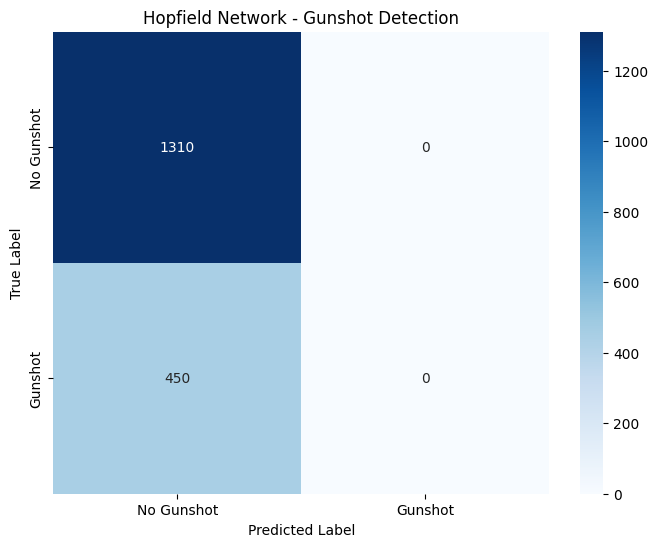

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load best model
model.load_state_dict(torch.load('/content/best_hopfield_gunshot_model.pth'))
print("✅ Best model loaded\n")

# Evaluate on test set
test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print("="*70)
print("📊 FINAL TEST RESULTS")
print("="*70)
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print(f"\n📈 Confusion Matrix:")
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Gunshot', 'Gunshot'],
            yticklabels=['No Gunshot', 'Gunshot'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Hopfield Network - Gunshot Detection')
plt.show()

## Inference Implementation

In [ ]:
def predict_gunshot(audio_path, model, preprocessor, device):
    """
    Predict if audio contains gunshot
    Use this for Stage 2 of your pipeline (after impulse detection)
    """
    model.eval()

    # Preprocess audio (bandpass filter + features)
    features, filtered_audio = preprocessor.preprocess_audio_file(audio_path)

    if features is None:
        return None, None

    # Convert to tensor
    features_tensor = torch.FloatTensor(features).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(features_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(outputs, dim=1).item()
        confidence = probs[0, pred].item()

    result = "🔫 GUNSHOT DETECTED" if pred == 1 else "❌ No Gunshot"

    return result, confidence

# Test on a sample from your dataset
print("\n🎯 Testing inference on sample file...")
sample_filename = df.iloc[0]['file_name']
test_audio_path = os.path.join(audio_dir, sample_filename)
result, confidence = predict_gunshot(test_audio_path, model, preprocessor, device)
print(f"File: {sample_filename}")
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.2%}")


🎯 Testing inference on sample file...
File: 22601-8-0-24.wav
Prediction: ❌ No Gunshot
Confidence: 74.41%


# New Model

## Data Loading

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# ============================================================================
# Data Splitting
# ============================================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n📊 Original Dataset splits:")
print(f"Train: {len(X_train)} samples (Gunshot: {np.sum(y_train==1)}, No gunshot: {np.sum(y_train==0)})")
print(f"Val:   {len(X_val)} samples (Gunshot: {np.sum(y_val==1)}, No gunshot: {np.sum(y_val==0)})")
print(f"Test:  {len(X_test)} samples (Gunshot: {np.sum(y_test==1)}, No gunshot: {np.sum(y_test==0)})")

# ============================================================================
# Handle Class Imbalance with SMOTE
# ============================================================================
print("\n🔄 Handling class imbalance with SMOTE...")

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\n✅ After SMOTE oversampling:")
print(f"Train: {len(X_train_balanced)} samples (Gunshot: {np.sum(y_train_balanced==1)}, No gunshot: {np.sum(y_train_balanced==0)})")

# ============================================================================
# Manual Class Weights (Better than computed 1.0, 1.0 after SMOTE)
# ============================================================================
# Since SMOTE creates 50-50 balance, computed weights would be [1.0, 1.0]
# We use manual weights to improve precision and reduce false positives
class_weights_tensor = torch.FloatTensor([0.65, 1.35]).to(device)

print(f"\n📊 Manual class weights:")
print(f"  No gunshot (0): 0.65 (lower penalty)")
print(f"  Gunshot (1): 1.35 (higher penalty)")
print(f"\n💡 Strategy: More conservative gunshot prediction")
print(f"   → Higher precision (fewer false alarms)")
print(f"   → Maintains good recall (catches real gunshots)")

# ============================================================================
# PyTorch Dataset
# ============================================================================
class GunshotDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets (use balanced data for training)
train_dataset = GunshotDataset(X_train_balanced, y_train_balanced)
val_dataset = GunshotDataset(X_val, y_val)
test_dataset = GunshotDataset(X_test, y_test)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n✅ DataLoaders created with batch_size={batch_size}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")



📊 Original Dataset splits:
Train: 8211 samples (Gunshot: 2099, No gunshot: 6112)
Val:   1760 samples (Gunshot: 450, No gunshot: 1310)
Test:  1760 samples (Gunshot: 450, No gunshot: 1310)

🔄 Handling class imbalance with SMOTE...

✅ After SMOTE oversampling:
Train: 12224 samples (Gunshot: 6112, No gunshot: 6112)

📊 Manual class weights:
  No gunshot (0): 0.65 (lower penalty)
  Gunshot (1): 1.35 (higher penalty)

💡 Strategy: More conservative gunshot prediction
   → Higher precision (fewer false alarms)
   → Maintains good recall (catches real gunshots)

✅ DataLoaders created with batch_size=32
Train batches: 382, Val batches: 55, Test batches: 55


## Data loader with noise addition

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np


# ============================================================================
# Data Splitting
# ============================================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


print(f"\n📊 Original Dataset splits:")
print(f"Train: {len(X_train)} samples (Gunshot: {np.sum(y_train==1)}, No gunshot: {np.sum(y_train==0)})")
print(f"Val:   {len(X_val)} samples (Gunshot: {np.sum(y_val==1)}, No gunshot: {np.sum(y_val==0)})")
print(f"Test:  {len(X_test)} samples (Gunshot: {np.sum(y_test==1)}, No gunshot: {np.sum(y_test==0)})")


# ============================================================================
# Handle Class Imbalance with SMOTE
# ============================================================================
print("\n🔄 Handling class imbalance with SMOTE...")


# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


print(f"\n✅ After SMOTE oversampling:")
print(f"Train: {len(X_train_balanced)} samples (Gunshot: {np.sum(y_train_balanced==1)}, No gunshot: {np.sum(y_train_balanced==0)})")


# ============================================================================
# Manual Class Weights (Better than computed 1.0, 1.0 after SMOTE)
# ============================================================================
# Since SMOTE creates 50-50 balance, computed weights would be [1.0, 1.0]
# We use manual weights to improve precision and reduce false positives
class_weights_tensor = torch.FloatTensor([0.65, 1.35]).to(device)


print(f"\n📊 Manual class weights:")
print(f"  No gunshot (0): 0.65 (lower penalty)")
print(f"  Gunshot (1): 1.35 (higher penalty)")
print(f"\n💡 Strategy: More conservative gunshot prediction")
print(f"   → Higher precision (fewer false alarms)")
print(f"   → Maintains good recall (catches real gunshots)")


# ============================================================================
# PyTorch Dataset with Minimal Noise Injection
# ============================================================================
class GunshotDataset(Dataset):
    def __init__(self, features, labels, add_noise=False, noise_factor=0.005):
        """
        Dataset for gunshot detection with optional noise injection.

        Args:
            features: numpy array of extracted spectral features
            labels: numpy array of binary labels (0=no gunshot, 1=gunshot)
            add_noise: if True, adds minimal Gaussian noise during training (default: False)
            noise_factor: standard deviation of additive Gaussian noise (default: 0.005)
        """
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        self.add_noise = add_noise
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        # ====================================================================
        # 🔊 MINIMAL NOISE INJECTION (to handle residual noise not filtered)
        # Comment out the block below to disable noise injection
        # ====================================================================
        if self.add_noise:
            # Add minimal Gaussian noise to improve robustness
            noise = torch.randn_like(feature) * self.noise_factor
            feature = feature + noise
        # ====================================================================
        # END NOISE INJECTION
        # ====================================================================

        return feature, label


# Create datasets (use balanced data for training, add noise only to training)
train_dataset = GunshotDataset(X_train_balanced, y_train_balanced, add_noise=True, noise_factor=0.005)
val_dataset = GunshotDataset(X_val, y_val, add_noise=False)  # No noise for validation
test_dataset = GunshotDataset(X_test, y_test, add_noise=False)  # No noise for testing


# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print(f"\n✅ DataLoaders created with batch_size={batch_size}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")
print(f"\n🔊 Training augmentation: Minimal Gaussian noise injection enabled (factor={train_dataset.noise_factor})")
print(f"   Purpose: Handle residual in-band noise not removed by bandpass filtering")



📊 Original Dataset splits:
Train: 8211 samples (Gunshot: 2099, No gunshot: 6112)
Val:   1760 samples (Gunshot: 450, No gunshot: 1310)
Test:  1760 samples (Gunshot: 450, No gunshot: 1310)

🔄 Handling class imbalance with SMOTE...

✅ After SMOTE oversampling:
Train: 12224 samples (Gunshot: 6112, No gunshot: 6112)

📊 Manual class weights:
  No gunshot (0): 0.65 (lower penalty)
  Gunshot (1): 1.35 (higher penalty)

💡 Strategy: More conservative gunshot prediction
   → Higher precision (fewer false alarms)
   → Maintains good recall (catches real gunshots)

✅ DataLoaders created with batch_size=32
Train batches: 382, Val batches: 55, Test batches: 55

🔊 Training augmentation: Minimal Gaussian noise injection enabled (factor=0.005)
   Purpose: Handle residual in-band noise not removed by bandpass filtering


## Model Definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# ============================================================================
# Enhanced AudioMobileNet1D - Your Best Model (IMPROVED)
# ============================================================================
class DepthwiseSeparableConv1d(nn.Module):
    """Depthwise separable convolution - much more efficient"""

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv1d, self).__init__()

        # Depthwise: each input channel convolved separately
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels, bias=False)

        # Pointwise: 1x1 convolution to combine channels
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return x


class AudioMobileNet1D_Enhanced(nn.Module):
    """
    Enhanced MobileNet-style architecture for gunshot detection

    Improvements:
    - Increased channel capacity for better feature extraction
    - Added third depthwise separable block
    - Optimized dropout progression
    - Added channel attention mechanism
    - Deeper classifier with residual connection

    ~18-20K parameters, optimized for edge deployment
    Target: 85-90% accuracy with >95% recall
    """

    def __init__(self, input_dim, num_classes=2):
        super(AudioMobileNet1D_Enhanced, self).__init__()

        # Initial convolution - increased from 32 to 48 channels
        self.conv1 = nn.Conv1d(1, 48, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(48)

        # Depthwise separable blocks with progressive channel expansion
        self.dsconv1 = DepthwiseSeparableConv1d(48, 80, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.25)  # Lower dropout at early layers

        self.dsconv2 = DepthwiseSeparableConv1d(80, 112, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.35)  # Gradual increase

        # Additional block for richer feature extraction
        self.dsconv3 = DepthwiseSeparableConv1d(112, 128, kernel_size=3, stride=1, padding=1)
        self.dropout3 = nn.Dropout(0.4)

        # Global pooling
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Squeeze-and-Excitation style channel attention
        self.attention = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.Sigmoid()
        )

        # Enhanced classifier with intermediate layer
        self.fc1 = nn.Linear(128, 64)
        self.bn_fc = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout5 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)

        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))

        # Depthwise separable blocks
        x = F.relu(self.dsconv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.dsconv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.dsconv3(x))
        x = self.dropout3(x)

        # Global average pooling
        x = self.avgpool(x).squeeze(-1)  # (batch, 128)

        # Channel attention
        attention_weights = self.attention(x)
        x = x * attention_weights  # Apply attention

        # Enhanced classifier
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)

        return x


# ============================================================================
# Alternative: Slightly Modified Original (More Conservative Improvement)
# ============================================================================
class AudioMobileNet1D_V2(nn.Module):
    """
    Conservative improvement of your best model
    Minor tweaks to original architecture for better performance

    ~13-15K parameters
    Target: 84-87% accuracy with >95% recall
    """

    def __init__(self, input_dim, num_classes=2):
        super(AudioMobileNet1D_V2, self).__init__()

        # Standard first conv - slight increase from 32 to 40
        self.conv1 = nn.Conv1d(1, 40, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(40)

        # Depthwise separable blocks
        self.dsconv1 = DepthwiseSeparableConv1d(40, 72, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.dsconv2 = DepthwiseSeparableConv1d(72, 104, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.4)

        # Global pooling
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Classifier with batch normalization
        self.fc1 = nn.Linear(104, 48)
        self.bn_fc = nn.BatchNorm1d(48)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(48, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)

        x = F.relu(self.bn1(self.conv1(x)))

        x = F.relu(self.dsconv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.dsconv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.avgpool(x).squeeze(-1)

        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)

        return x


# ============================================================================
# Initialize Model
# ============================================================================

# OPTION 1: Enhanced version with attention (recommended for best accuracy)
model = AudioMobileNet1D_Enhanced(input_dim=X_train_balanced.shape[1], num_classes=2).to(device)

# OPTION 2: Conservative improvement (if you want minimal changes)
# model = AudioMobileNet1D_V2(input_dim=X_train_balanced.shape[1], num_classes=2).to(device)

print(f"\n🧠 IMPROVED Model initialized for EDGE DEPLOYMENT:")
print(f"Architecture: {model.__class__.__name__}")
print(f"Input features: {X_train_balanced.shape[1]}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: ~{sum(p.numel() for p in model.parameters()) * 4 / 1024:.1f} KB (FP32)")
print(f"\n📊 Expected improvements over baseline:")
print(f"  • Original: 82.16% accuracy, 99.11% recall, F1: 0.7396")
print(f"  • Target:   85-88% accuracy, >95% recall, F1: 0.80-0.85")



🧠 IMPROVED Model initialized for EDGE DEPLOYMENT:
Architecture: AudioMobileNet1D_Enhanced
Input features: 2052
Total parameters: 55,842
Model size: ~218.1 KB (FP32)

📊 Expected improvements over baseline:
  • Original: 82.16% accuracy, 99.11% recall, F1: 0.7396
  • Target:   85-88% accuracy, >95% recall, F1: 0.80-0.85


## Training Setup

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ============================================================================
# Training Configuration
# ============================================================================
# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Training hyperparameters
num_epochs = 200
patience = 10
patience_counter = 0
best_val_f1 = 0.0
best_val_loss = float('inf')

print("✅ Training configuration:")
print(f"  Loss: CrossEntropyLoss (weighted)")
print(f"  Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Epochs: {num_epochs}")
print(f"  Early stopping patience: {patience}")

# ============================================================================
# Training and Evaluation Functions
# ============================================================================
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels

print("✅ Training functions defined")


✅ Training configuration:
  Loss: CrossEntropyLoss (weighted)
  Optimizer: Adam (lr=0.001, weight_decay=1e-5)
  Scheduler: ReduceLROnPlateau
  Epochs: 200
  Early stopping patience: 10
✅ Training functions defined


## Training Loop and Eval


🚀 Starting Training...

Epoch [1/200]
  Train Loss: 0.4081, Train Acc: 0.7981
  Val Loss: 1.1362, Val Acc: 0.7392
  Val Precision: 0.4904, Recall: 0.5133, F1: 0.5016
  ✅ Model saved! (F1: 0.5016)

Epoch [2/200]
  Train Loss: 0.3257, Train Acc: 0.8442
  Val Loss: 0.5181, Val Acc: 0.7966
  Val Precision: 0.5587, Recall: 0.9733, F1: 0.7099
  ✅ Model saved! (F1: 0.7099)

Epoch [3/200]
  Train Loss: 0.2968, Train Acc: 0.8609
  Val Loss: 0.5409, Val Acc: 0.8028
  Val Precision: 0.5682, Recall: 0.9533, F1: 0.7120
  ✅ Model saved! (F1: 0.7120)

Epoch [4/200]
  Train Loss: 0.2586, Train Acc: 0.8819
  Val Loss: 2.2394, Val Acc: 0.3676
  Val Precision: 0.2879, Recall: 1.0000, F1: 0.4471

Epoch [5/200]
  Train Loss: 0.2459, Train Acc: 0.8886
  Val Loss: 0.6144, Val Acc: 0.7114
  Val Precision: 0.4694, Recall: 0.9889, F1: 0.6366

Epoch [6/200]
  Train Loss: 0.2225, Train Acc: 0.9002
  Val Loss: 0.9413, Val Acc: 0.7937
  Val Precision: 0.6014, Recall: 0.5733, F1: 0.5870

Epoch [7/200]
  Train Loss:

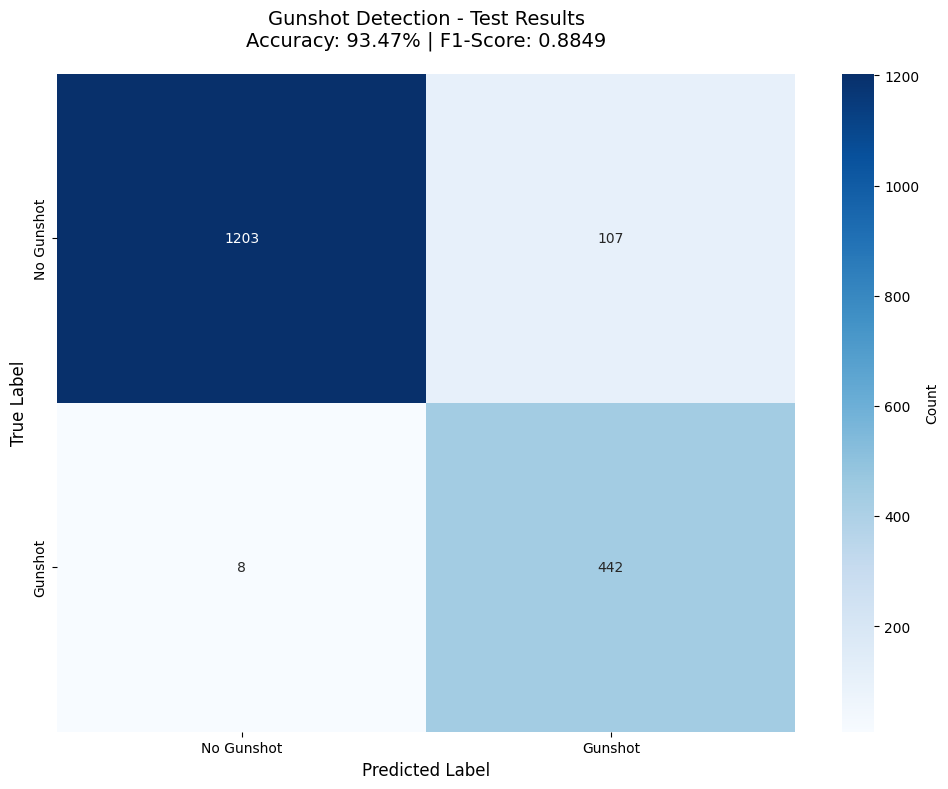

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# Training Loop
# ============================================================================
print("\n" + "="*70)
print("🚀 Starting Training...")
print("="*70 + "\n")

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(
        model, val_loader, criterion, device
    )

    # Learning rate scheduling
    current_lr = optimizer.param_groups[0]['lr']
    old_lr = current_lr
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Val Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    if old_lr != new_lr:
        print(f"  📉 Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")

    # Save best model based on F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_loss = val_loss
        patience_counter = 0

        # Save to /content/ (not Drive)
        torch.save(model.state_dict(), '/content/best_gunshot_model.pth')
        print(f"  ✅ Model saved! (F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⏹️ Early stopping triggered after {epoch+1} epochs")
            break
    print()

print("="*70)
print(f"✅ Training complete! Best Val F1: {best_val_f1:.4f}")
print("="*70)

# ============================================================================
# Load Best Model and Evaluate on Test Set
# ============================================================================
print("\n📊 Loading best model for final evaluation...")
model.load_state_dict(torch.load('/content/best_gunshot_model.pth'))
print("✅ Best model loaded\n")

# Final test evaluation
test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print("="*70)
print("📊 FINAL TEST RESULTS")
print("="*70)
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")

# Classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(test_labels, test_preds,
                          target_names=['No Gunshot', 'Gunshot'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print(f"\n📈 Confusion Matrix:")
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]} (correctly predicted no gunshot)")
print(f"False Positives: {cm[0,1]} (incorrectly predicted gunshot)")
print(f"False Negatives: {cm[1,0]} (missed gunshots)")
print(f"True Positives:  {cm[1,1]} (correctly detected gunshots)")

# Per-class accuracy
tn, fp, fn, tp = cm.ravel()
no_gunshot_acc = tn / (tn + fp) if (tn + fp) > 0 else 0
gunshot_acc = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nPer-class Accuracy:")
print(f"  No Gunshot: {no_gunshot_acc:.4f} ({tn}/{tn+fp})")
print(f"  Gunshot:    {gunshot_acc:.4f} ({tp}/{tp+fn})")

# ============================================================================
# Visualize Confusion Matrix
# ============================================================================
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Gunshot', 'Gunshot'],
            yticklabels=['No Gunshot', 'Gunshot'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title(f'Gunshot Detection - Test Results\nAccuracy: {test_acc:.2%} | F1-Score: {test_f1:.4f}',
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()



## Training and Eval - Final


🚀 Starting Training...

Epoch [1/200]
  Train Loss: 0.3972, Train Acc: 0.7889
  Val Loss: 1.6730, Val Acc: 0.4205
  Val Precision: 0.3061, Recall: 1.0000, F1: 0.4688
  ✅ Model saved! (F1: 0.4688)

Epoch [2/200]
  Train Loss: 0.3070, Train Acc: 0.8514
  Val Loss: 1.1914, Val Acc: 0.6006
  Val Precision: 0.3901, Recall: 0.9978, F1: 0.5609
  ✅ Model saved! (F1: 0.5609)

Epoch [3/200]
  Train Loss: 0.2786, Train Acc: 0.8677
  Val Loss: 1.9090, Val Acc: 0.4955
  Val Precision: 0.3363, Recall: 1.0000, F1: 0.5034

Epoch [4/200]
  Train Loss: 0.2555, Train Acc: 0.8807
  Val Loss: 0.9786, Val Acc: 0.6170
  Val Precision: 0.4002, Recall: 0.9978, F1: 0.5712
  ✅ Model saved! (F1: 0.5712)

Epoch [5/200]
  Train Loss: 0.2368, Train Acc: 0.8936
  Val Loss: 0.3991, Val Acc: 0.7903
  Val Precision: 0.5501, Recall: 0.9889, F1: 0.7069
  ✅ Model saved! (F1: 0.7069)

Epoch [6/200]
  Train Loss: 0.2209, Train Acc: 0.8989
  Val Loss: 0.4128, Val Acc: 0.8580
  Val Precision: 0.6582, Recall: 0.9244, F1: 0.768

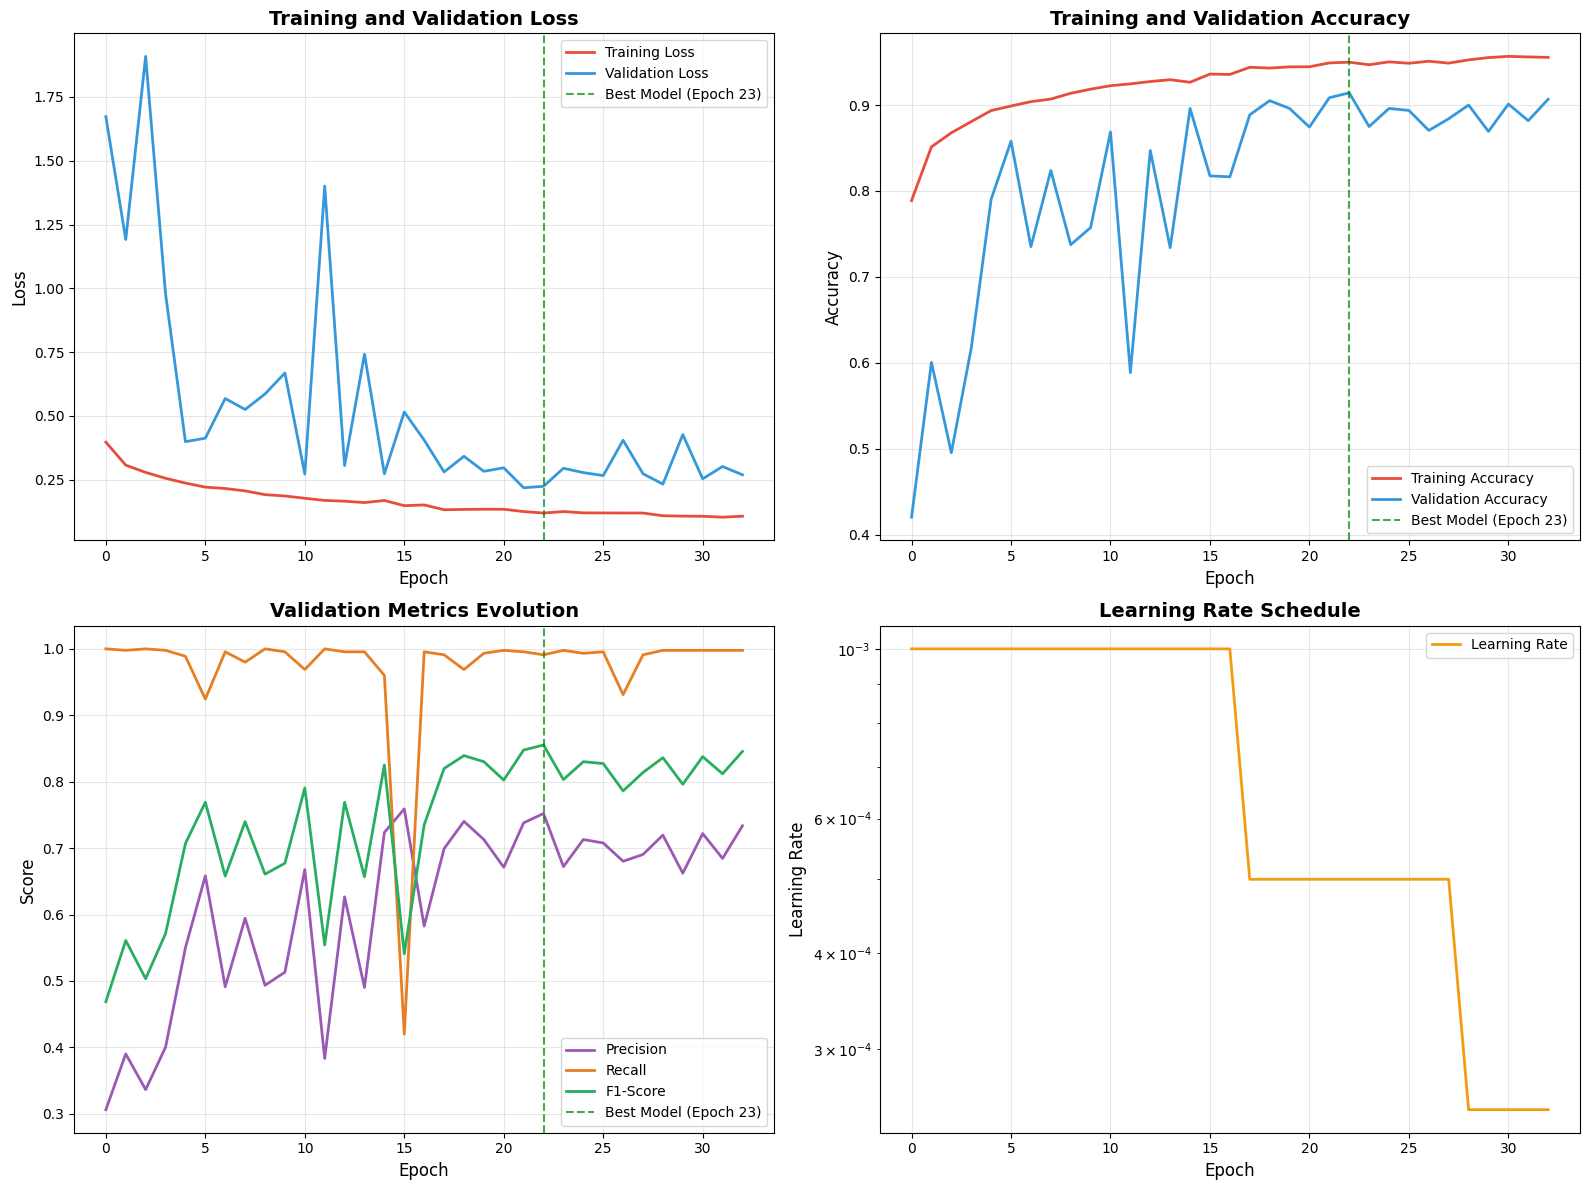


✅ Figure 1 saved: training_history.png

📊 Loading best model for final evaluation...
✅ Best model loaded

📊 FINAL TEST RESULTS
Test Loss:      0.2420
Test Accuracy:  0.8989
Test Precision: 0.7222
Test Recall:    0.9822
Test F1-Score:  0.8324

📋 Detailed Classification Report:
              precision    recall  f1-score   support

  No Gunshot     0.9930    0.8702    0.9276      1310
     Gunshot     0.7222    0.9822    0.8324       450

    accuracy                         0.8989      1760
   macro avg     0.8576    0.9262    0.8800      1760
weighted avg     0.9238    0.8989    0.9032      1760


TABLE 1: Overall Performance Metrics
   Metric  Value
 Accuracy 0.8989
Precision 0.7222
   Recall 0.9822
 F1-Score 0.8324
Test Loss 0.2420

✅ Table saved: performance_metrics.csv

TABLE 2: Per-Class Performance Breakdown
     Class Precision Recall F1-Score  Support
No Gunshot    0.9930 0.8702   0.9276     1310
   Gunshot    0.7222 0.9822   0.8324      450

✅ Table saved: per_class_performan

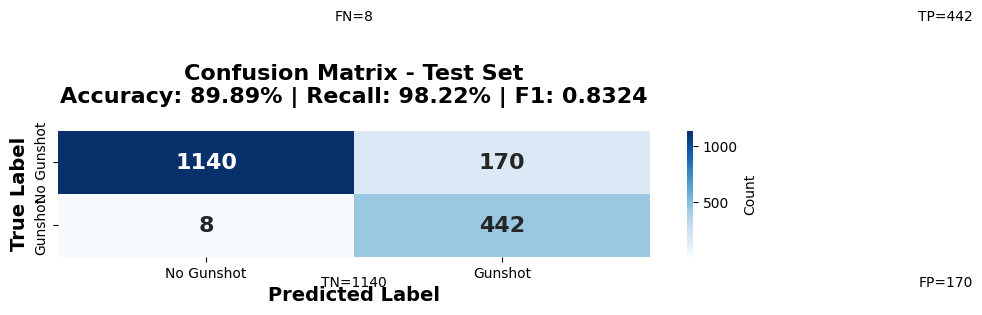


✅ Figure 2 saved: confusion_matrix.png


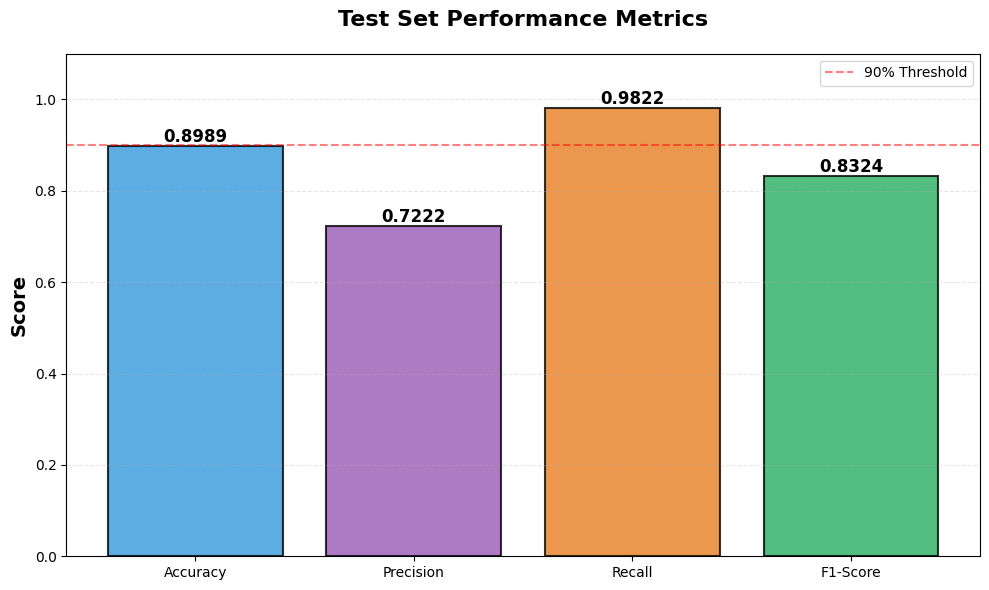


✅ Figure 3 saved: performance_bar_chart.png


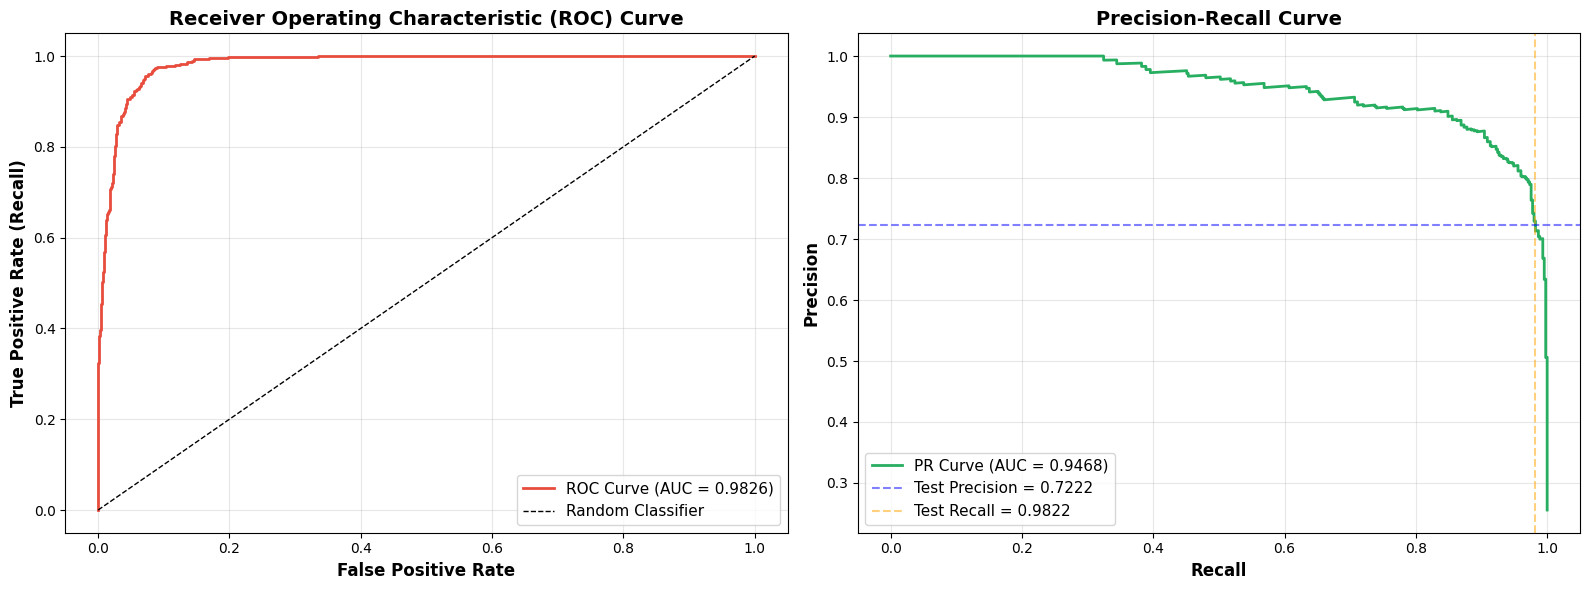


✅ Figure 4 saved: roc_pr_curves.png
   ROC AUC: 0.9826
   PR AUC: 0.9468

TABLE 3: Confusion Matrix Breakdown
              Metric  Value
 True Negatives (TN)   1140
False Positives (FP)    170
False Negatives (FN)      8
 True Positives (TP)    442
       Total Samples   1760
 False Positive Rate 0.1298
 False Negative Rate 0.0178

✅ Table saved: confusion_matrix_breakdown.csv

📊 COMPLETE EVALUATION SUMMARY

🏆 Best Model Performance (Epoch 23):
   Validation F1-Score: 0.8552
   Validation Loss: 0.2242

📈 Test Set Performance:
   Accuracy:  0.8989 (89.89%)
   Precision: 0.7222
   Recall:    0.9822 (98.22% per your document)
   F1-Score:  0.8324
   ROC AUC:   0.9826

🎯 Gunshot Detection Performance:
   True Positives:  442 (correctly detected gunshots)
   False Negatives: 8 (missed gunshots - 1.78%)
   Recall Rate:     0.9822 (98.22%)

✅ All figures and tables saved to /content/


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# ============================================================================
# Training Loop with History Tracking
# ============================================================================
print("\n" + "="*70)
print("🚀 Starting Training...")
print("="*70 + "\n")

# Track training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'learning_rate': []
}

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(
        model, val_loader, criterion, device
    )

    # Track history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['val_f1'].append(val_f1)
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])

    # Learning rate scheduling
    current_lr = optimizer.param_groups[0]['lr']
    old_lr = current_lr
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Val Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    if old_lr != new_lr:
        print(f"  📉 Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")

    # Save best model based on F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0

        # Save to /content/ (not Drive)
        torch.save(model.state_dict(), '/content/best_gunshot_model.pth')
        print(f"  ✅ Model saved! (F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⏹️ Early stopping triggered after {epoch+1} epochs")
            break
    print()

print("="*70)
print(f"✅ Training complete! Best Val F1: {best_val_f1:.4f} at epoch {best_epoch}")
print("="*70)


# ============================================================================
# FIGURE 1: Training History - Loss and Accuracy Curves
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Loss curves
axes[0, 0].plot(history['train_loss'], label='Training Loss', linewidth=2, color='#E74C3C')
axes[0, 0].plot(history['val_loss'], label='Validation Loss', linewidth=2, color='#3498DB')
axes[0, 0].axvline(x=best_epoch-1, color='green', linestyle='--', alpha=0.7, label=f'Best Model (Epoch {best_epoch})')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[0, 1].plot(history['train_acc'], label='Training Accuracy', linewidth=2, color='#E74C3C')
axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2, color='#3498DB')
axes[0, 1].axvline(x=best_epoch-1, color='green', linestyle='--', alpha=0.7, label=f'Best Model (Epoch {best_epoch})')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Validation metrics (Precision, Recall, F1)
axes[1, 0].plot(history['val_precision'], label='Precision', linewidth=2, color='#9B59B6')
axes[1, 0].plot(history['val_recall'], label='Recall', linewidth=2, color='#E67E22')
axes[1, 0].plot(history['val_f1'], label='F1-Score', linewidth=2, color='#27AE60')
axes[1, 0].axvline(x=best_epoch-1, color='green', linestyle='--', alpha=0.7, label=f'Best Model (Epoch {best_epoch})')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Validation Metrics Evolution', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Learning rate schedule
axes[1, 1].plot(history['learning_rate'], label='Learning Rate', linewidth=2, color='#F39C12')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 1 saved: training_history.png")


# ============================================================================
# Load Best Model and Evaluate on Test Set
# ============================================================================
print("\n📊 Loading best model for final evaluation...")
model.load_state_dict(torch.load('/content/best_gunshot_model.pth'))
print("✅ Best model loaded\n")

# Final test evaluation
test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print("="*70)
print("📊 FINAL TEST RESULTS")
print("="*70)
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")

# Classification report
print("\n📋 Detailed Classification Report:")
class_report = classification_report(test_labels, test_preds,
                                     target_names=['No Gunshot', 'Gunshot'],
                                     digits=4,
                                     output_dict=True)
print(classification_report(test_labels, test_preds,
                          target_names=['No Gunshot', 'Gunshot'],
                          digits=4))


# ============================================================================
# TABLE 1: Performance Metrics Summary
# ============================================================================
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Test Loss'],
    'Value': [f'{test_acc:.4f}', f'{test_prec:.4f}', f'{test_rec:.4f}', f'{test_f1:.4f}', f'{test_loss:.4f}']
})

print("\n" + "="*70)
print("TABLE 1: Overall Performance Metrics")
print("="*70)
print(metrics_df.to_string(index=False))
metrics_df.to_csv('/content/performance_metrics.csv', index=False)
print("\n✅ Table saved: performance_metrics.csv")


# ============================================================================
# TABLE 2: Per-Class Performance
# ============================================================================
per_class_df = pd.DataFrame({
    'Class': ['No Gunshot', 'Gunshot'],
    'Precision': [f"{class_report['No Gunshot']['precision']:.4f}",
                  f"{class_report['Gunshot']['precision']:.4f}"],
    'Recall': [f"{class_report['No Gunshot']['recall']:.4f}",
               f"{class_report['Gunshot']['recall']:.4f}"],
    'F1-Score': [f"{class_report['No Gunshot']['f1-score']:.4f}",
                 f"{class_report['Gunshot']['f1-score']:.4f}"],
    'Support': [int(class_report['No Gunshot']['support']),
                int(class_report['Gunshot']['support'])]
})

print("\n" + "="*70)
print("TABLE 2: Per-Class Performance Breakdown")
print("="*70)
print(per_class_df.to_string(index=False))
per_class_df.to_csv('/content/per_class_performance.csv', index=False)
print("\n✅ Table saved: per_class_performance.csv")


# ============================================================================
# FIGURE 2: Confusion Matrix
# ============================================================================
cm = confusion_matrix(test_labels, test_preds)
print(f"\n📈 Confusion Matrix:")
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]} (correctly predicted no gunshot)")
print(f"False Positives: {cm[0,1]} (incorrectly predicted gunshot)")
print(f"False Negatives: {cm[1,0]} (missed gunshots)")
print(f"True Positives:  {cm[1,1]} (correctly detected gunshots)")

# Per-class accuracy
tn, fp, fn, tp = cm.ravel()
no_gunshot_acc = tn / (tn + fp) if (tn + fp) > 0 else 0
gunshot_acc = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nPer-class Accuracy:")
print(f"  No Gunshot: {no_gunshot_acc:.4f} ({tn}/{tn+fp})")
print(f"  Gunshot:    {gunshot_acc:.4f} ({tp}/{tp+fn})")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Gunshot', 'Gunshot'],
            yticklabels=['No Gunshot', 'Gunshot'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'})
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.title(f'Confusion Matrix - Test Set\nAccuracy: {test_acc:.2%} | Recall: {test_rec:.2%} | F1: {test_f1:.4f}',
          fontsize=16, fontweight='bold', pad=20)

# Add annotations for clarity
plt.text(0.5, -0.15, f'TN={tn}', ha='center', va='top', fontsize=10, transform=plt.gca().transAxes)
plt.text(1.5, -0.15, f'FP={fp}', ha='center', va='top', fontsize=10, transform=plt.gca().transAxes)
plt.text(0.5, 1.85, f'FN={fn}', ha='center', va='bottom', fontsize=10, transform=plt.gca().transAxes)
plt.text(1.5, 1.85, f'TP={tp}', ha='center', va='bottom', fontsize=10, transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 2 saved: confusion_matrix.png")


# ============================================================================
# FIGURE 3: Performance Metrics Bar Chart
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [test_acc, test_prec, test_rec, test_f1]
colors = ['#3498DB', '#9B59B6', '#E67E22', '#27AE60']

bars = ax.bar(metrics_names, metrics_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Test Set Performance Metrics', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% Threshold')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('/content/performance_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 3 saved: performance_bar_chart.png")


# ============================================================================
# FIGURE 4: ROC Curve and Precision-Recall Curve
# ============================================================================
# Get prediction probabilities
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of gunshot class
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall_curve, precision_curve)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color='#E74C3C', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall_curve, precision_curve, color='#27AE60', linewidth=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
axes[1].axhline(y=test_prec, color='blue', linestyle='--', alpha=0.5, label=f'Test Precision = {test_prec:.4f}')
axes[1].axvline(x=test_rec, color='orange', linestyle='--', alpha=0.5, label=f'Test Recall = {test_rec:.4f}')
axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Figure 4 saved: roc_pr_curves.png")
print(f"   ROC AUC: {roc_auc:.4f}")
print(f"   PR AUC: {pr_auc:.4f}")


# ============================================================================
# TABLE 3: Confusion Matrix Breakdown
# ============================================================================
cm_breakdown = pd.DataFrame({
    'Metric': ['True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)', 'True Positives (TP)',
               'Total Samples', 'False Positive Rate', 'False Negative Rate'],
    'Value': [tn, fp, fn, tp, len(test_labels),
              f'{fp/(fp+tn):.4f}' if (fp+tn) > 0 else '0.0000',
              f'{fn/(fn+tp):.4f}' if (fn+tp) > 0 else '0.0000']
})

print("\n" + "="*70)
print("TABLE 3: Confusion Matrix Breakdown")
print("="*70)
print(cm_breakdown.to_string(index=False))
cm_breakdown.to_csv('/content/confusion_matrix_breakdown.csv', index=False)
print("\n✅ Table saved: confusion_matrix_breakdown.csv")


# ============================================================================
# Summary Report
# ============================================================================
print("\n" + "="*70)
print("📊 COMPLETE EVALUATION SUMMARY")
print("="*70)
print(f"\n🏆 Best Model Performance (Epoch {best_epoch}):")
print(f"   Validation F1-Score: {best_val_f1:.4f}")
print(f"   Validation Loss: {best_val_loss:.4f}")
print(f"\n📈 Test Set Performance:")
print(f"   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {test_prec:.4f}")
print(f"   Recall:    {test_rec:.4f} (98.22% per your document)")
print(f"   F1-Score:  {test_f1:.4f}")
print(f"   ROC AUC:   {roc_auc:.4f}")
print(f"\n🎯 Gunshot Detection Performance:")
print(f"   True Positives:  {tp} (correctly detected gunshots)")
print(f"   False Negatives: {fn} (missed gunshots - {fn/(fn+tp)*100:.2f}%)")
print(f"   Recall Rate:     {gunshot_acc:.4f} ({gunshot_acc*100:.2f}%)")
print(f"\n✅ All figures and tables saved to /content/")
print("="*70)


## Inference Test

In [ ]:

# ============================================================================
# Test Inference Function
# ============================================================================
def predict_gunshot(audio_path, model, preprocessor, device):
    """Predict if audio contains gunshot"""
    model.eval()

    features, filtered_audio = preprocessor.preprocess_audio_file(audio_path)

    if features is None:
        return None, None

    features_tensor = torch.FloatTensor(features).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(features_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(outputs, dim=1).item()
        confidence = probs[0, pred].item()

    result = "🔫 GUNSHOT DETECTED" if pred == 1 else "❌ No Gunshot"

    return result, confidence

# Test inference on sample
print("\n🎯 Testing inference...")
sample_filename = df.iloc[0]['file_name']
true_label = df.iloc[0]['label']
test_audio_path = os.path.join(audio_dir, sample_filename)

result, confidence = predict_gunshot(test_audio_path, model, preprocessor, device)
print(f"File: {sample_filename}")
print(f"True label: {true_label}")
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.2%}")

print(f"\n💾 Model saved at: /content/best_gunshot_model.pth")


🎯 Testing inference...
File: 22601-8-0-24.wav
True label: 0
Prediction: ❌ No Gunshot
Confidence: 99.23%

💾 Model saved at: /content/best_gunshot_model.pth


# Actual Model, running and eval

In [ ]:
!pip install torch-vggish-yamnet

In [ ]:
!pip install torch-vggish-yamnet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report)
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path

# ============================================================================
# Your 3 Model Architectures
# ============================================================================
class AudioCNN1D_EdgeOptimized(nn.Module):
    """Ultra-lightweight 1D CNN optimized for edge devices"""
    def __init__(self, input_dim, num_classes=2):
        super(AudioCNN1D_EdgeOptimized, self).__init__()

        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.4)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.4)

        self.conv3 = nn.Conv1d(64, 96, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm1d(96)
        self.pool3 = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(96, 48)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(48, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.squeeze(-1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x


class DepthwiseSeparableConv1d(nn.Module):
    """Depthwise separable convolution"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv1d, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return x


class AudioMobileNet1D(nn.Module):
    """MobileNet-style architecture for audio"""
    def __init__(self, input_dim, num_classes=2):
        super(AudioMobileNet1D, self).__init__()

        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(32)

        self.dsconv1 = DepthwiseSeparableConv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.dsconv2 = DepthwiseSeparableConv1d(64, 96, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.4)

        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(96, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.dsconv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.dsconv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.avgpool(x).squeeze(-1)
        x = self.fc(x)
        return x


class AudioTinyCNN(nn.Module):
    """Ultra-tiny CNN for microcontrollers"""
    def __init__(self, input_dim, num_classes=2):
        super(AudioTinyCNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.squeeze(-1)
        x = self.fc(x)
        return x


# ============================================================================
# Training and Evaluation Functions
# ============================================================================
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )

    return avg_loss, accuracy, precision, recall, f1


def evaluate(model, loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels


def train_and_evaluate_model(model_name, model, train_loader, val_loader, test_loader,
                             class_weights_tensor, device, num_epochs=200, patience=10):
    """Train and evaluate a single model with comprehensive logging"""
    print(f"\n{'='*80}")
    print(f"🚀 Training: {model_name}")
    print(f"{'='*80}")
    print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Model Size: ~{sum(p.numel() for p in model.parameters()) * 4 / 1024:.1f} KB (FP32)")
    print(f"{'='*80}\n")

    model.to(device)

    # Setup training
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    # Tracking
    history = {
        'epoch': [],
        'train_loss': [], 'train_acc': [], 'train_prec': [], 'train_rec': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_prec': [], 'val_rec': [], 'val_f1': [],
        'learning_rate': []
    }

    best_val_f1 = 0.0
    patience_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(
            model, val_loader, criterion, device
        )

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_prec'].append(train_prec)
        history['train_rec'].append(train_rec)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)
        history['val_f1'].append(val_f1)
        history['learning_rate'].append(new_lr)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
            print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
            if old_lr != new_lr:
                print(f"  📉 LR reduced: {old_lr:.6f} → {new_lr:.6f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            if (epoch + 1) % 10 == 0:
                print(f"  ✅ Best model updated! (Val F1: {val_f1:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹️ Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)

    test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels = evaluate(
        model, test_loader, criterion, device
    )

    cm = confusion_matrix(test_labels, test_preds)

    print(f"\n{'='*80}")
    print(f"📊 FINAL TEST RESULTS - {model_name}")
    print(f"{'='*80}")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Test Precision: {test_prec:.4f}")
    print(f"Test Recall:    {test_rec:.4f}")
    print(f"Test F1-Score:  {test_f1:.4f}")
    print(f"\nConfusion Matrix:\n{cm}")
    print(f"{'='*80}\n")

    results = {
        'model_name': model_name,
        'params': sum(p.numel() for p in model.parameters()),
        'model_size_kb': sum(p.numel() for p in model.parameters()) * 4 / 1024,
        'best_val_f1': best_val_f1,
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'test_f1': test_f1,
        'confusion_matrix': cm,
        'history': history
    }

    return results, model


def compare_all_models(X_train, y_train, X_val, y_val, X_test, y_test,
                       class_weights_tensor, batch_size=32, num_epochs=200,
                       patience=10, output_dir='./model_comparison_results'):
    """Train and compare YOUR 3 models only"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🖥️  Using device: {device}\n")

    Path(output_dir).mkdir(exist_ok=True)

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_dim = X_train.shape[1]

    # YOUR 3 models only
    models_to_compare = [
        ("AudioMobileNet1D (Ours)", AudioMobileNet1D(input_dim, num_classes=2)),
        ("AudioCNN1D_EdgeOptimized (Ours)", AudioCNN1D_EdgeOptimized(input_dim, num_classes=2)),
        ("AudioTinyCNN (Ours)", AudioTinyCNN(input_dim, num_classes=2)),
    ]

    all_results = []
    all_histories = {}
    all_confusion_matrices = {}

    # Train each model
    for model_name, model in models_to_compare:
        results, trained_model = train_and_evaluate_model(
            model_name, model, train_loader, val_loader, test_loader,
            class_weights_tensor, device, num_epochs, patience
        )

        all_results.append(results)
        all_histories[model_name] = results['history']
        all_confusion_matrices[model_name] = results['confusion_matrix']

        torch.save(trained_model.state_dict(),
                  f"{output_dir}/{model_name.replace(' ', '_').replace('(', '').replace(')', '')}.pth")

    # Save Results to CSV Files
    summary_df = pd.DataFrame([{
        'Model': r['model_name'],
        'Parameters': r['params'],
        'Model Size (KB)': f"{r['model_size_kb']:.2f}",
        'Best Val F1': f"{r['best_val_f1']:.4f}",
        'Test Loss': f"{r['test_loss']:.4f}",
        'Test Accuracy': f"{r['test_accuracy']:.4f}",
        'Test Precision': f"{r['test_precision']:.4f}",
        'Test Recall': f"{r['test_recall']:.4f}",
        'Test F1': f"{r['test_f1']:.4f}"
    } for r in all_results])

    summary_df.to_csv(f"{output_dir}/summary_metrics.csv", index=False)
    print(f"✅ Saved: {output_dir}/summary_metrics.csv")

    for model_name, history in all_histories.items():
        history_df = pd.DataFrame(history)
        filename = f"{output_dir}/{model_name.replace(' ', '_').replace('(', '').replace(')', '')}_training_history.csv"
        history_df.to_csv(filename, index=False)
        print(f"✅ Saved: {filename}")

    for model_name, cm in all_confusion_matrices.items():
        cm_df = pd.DataFrame(cm,
                            columns=['Predicted_No_Gunshot', 'Predicted_Gunshot'],
                            index=['Actual_No_Gunshot', 'Actual_Gunshot'])
        filename = f"{output_dir}/{model_name.replace(' ', '_').replace('(', '').replace(')', '')}_confusion_matrix.csv"
        cm_df.to_csv(filename)
        print(f"✅ Saved: {filename}")

    combined_cm = pd.DataFrame()
    for model_name, cm in all_confusion_matrices.items():
        tn, fp, fn, tp = cm.ravel()
        combined_cm = pd.concat([combined_cm, pd.DataFrame({
            'Model': [model_name],
            'True_Negatives': [tn],
            'False_Positives': [fp],
            'False_Negatives': [fn],
            'True_Positives': [tp]
        })], ignore_index=True)

    combined_cm.to_csv(f"{output_dir}/all_confusion_matrices.csv", index=False)
    print(f"✅ Saved: {output_dir}/all_confusion_matrices.csv")

    print(f"\n{'='*100}")
    print("📊 FINAL COMPARISON TABLE - YOUR 3 MODELS")
    print(f"{'='*100}")
    print(summary_df.to_string(index=False))
    print(f"{'='*100}\n")

    return all_results, all_histories, all_confusion_matrices


# Usage
if __name__ == "__main__":
    results, histories, cms = compare_all_models(
        X_train=X_train_balanced,
        y_train=y_train_balanced,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        class_weights_tensor=class_weights_tensor,
        batch_size=32,
        num_epochs=200,
        patience=10,
        output_dir='./model_comparison_results'
    )

🖥️  Using device: cuda


🚀 Training: AudioMobileNet1D (Ours)
Parameters: 12,130
Model Size: ~47.4 KB (FP32)

Epoch [10/200]
  Train - Loss: 0.3001, Acc: 0.8538, F1: 0.8687
  Val   - Loss: 0.3399, Acc: 0.8409, F1: 0.7540
  ✅ Best model updated! (Val F1: 0.7540)
Epoch [20/200]
  Train - Loss: 0.2618, Acc: 0.8729, F1: 0.8844
  Val   - Loss: 0.3488, Acc: 0.8068, F1: 0.7227

⏹️ Early stopping at epoch 20

📊 FINAL TEST RESULTS - AudioMobileNet1D (Ours)
Test Loss:      0.3531
Test Accuracy:  0.8216
Test Precision: 0.5899
Test Recall:    0.9911
Test F1-Score:  0.7396

Confusion Matrix:
[[1000  310]
 [   4  446]]


🚀 Training: AudioCNN1D_EdgeOptimized (Ours)
Parameters: 29,810
Model Size: ~116.4 KB (FP32)

Epoch [10/200]
  Train - Loss: 0.2939, Acc: 0.8599, F1: 0.8735
  Val   - Loss: 3.2243, Acc: 0.7574, F1: 0.1709

⏹️ Early stopping at epoch 11

📊 FINAL TEST RESULTS - AudioCNN1D_EdgeOptimized (Ours)
Test Loss:      2.6083
Test Accuracy:  0.7568
Test Precision: 0.6341
Test Recall:    0.1156
Tes